# Chess Piece Identifier

In this project I will build a Deep Learning Model, more specifically an Image recognition model. My plan is to use a convolutional neural network.

My Model will be able to identify chess pieces from a picture. The chess pieces are Pawn, Knight, Bishop, Rook, Queen and King. 
The dataset I will use is from Kaggle (https://www.kaggle.com/datasets/anshulmehtakaggl/chess-pieces-detection-images-dataset).

I will be using PyTorch which is the Deep Learning library I feel most at home with. The images I have loaded into a folder. So let's get going.

In [77]:
from fastai.vision.all import *
from PIL import ImageFile
import os
import matplotlib.pyplot as plt
import pandas as pd

Let's analyze our dataset. 

In [71]:
path = "img"
sub_dir = [folder.path for folder in os.scandir(path) if folder.is_dir()]
plot_dict = {}
for sub in sub_dir:
    files = os.listdir(sub)
    plot_dict[sub.split("-")[0]]= len(files)

df = pd.DataFrame.from_dict(plot_dict,orient='index', columns=["count"])
df.head()


,count
img\bishop_resized,141
img\knight,174
img\pawn_resized,82
img\Queen,115
img\Rook,139


<AxesSubplot:>

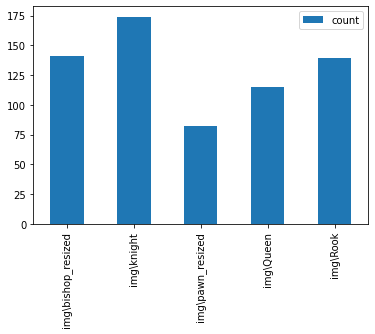

In [74]:
df.plot(kind='bar')

The distribution is not perfectly even, but it will do for the problems. 

Let's load it into PyTorches ImageDataLoader. I will use 20% for Testing. For the first test to sped up the learning I am reducing the the image size to 64x64 pixels, and I will use the squish method if the dimensions are different. 

In [35]:
dls64 = ImageDataLoaders.from_folder(path, valid_pct = 0.2, item_tfms=Resize(64, ResizeMethod.Squish))

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


Let's look at some images.

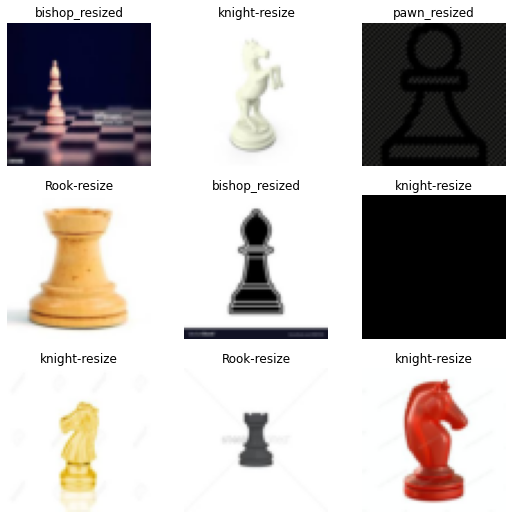

In [36]:
dls64.show_batch()

The data comes pre cleaned so we don't need to remove any outliers. 

In [37]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Model Learning

Now let's do some learning. I will be using resnet50 as the pretrained CNN. The metrics I chose for the initial learning is accuracy and precision. 


In [38]:
learn64 = vision_learner(dls64, resnet50,  metrics=[accuracy,
               Precision(average='macro')])

In [39]:
learn64.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,precision_score,time
0,2.719618,1.767218,0.369231,0.442651,00:08
1,2.184647,1.268401,0.607692,0.591374,00:08
2,1.727865,1.271961,0.661538,0.641767,00:08
3,1.406288,1.370152,0.600000,0.570584,00:08
4,1.161977,1.446343,0.638462,0.611659,00:08
5,0.948633,1.406641,0.669231,0.645702,00:08
6,0.800073,1.411143,0.669231,0.644377,00:08
7,0.695056,1.419425,0.653846,0.628936,00:08
8,0.611299,1.415756,0.653846,0.625329,00:08
9,0.534207,1.395704,0.653846,0.626741,00:08


#### PROBLEM OVERFITTING!!
We heavily overfit here, we can see that after the 2nd epoch we aren't improving anymore. This is an issue. So let's add some early stopping if our valid_loss stops improving. 

So let's try again with the early stopping. 

In [40]:
learn64 = vision_learner(dls64, resnet50, metrics=[accuracy,
               Precision(average='macro'),
               Recall(average='macro')], cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=2))

In [41]:
learn64.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,2.529222,1.531807,0.438462,0.418992,0.409454,00:08
1,2.070783,1.314914,0.592308,0.584372,0.572108,00:08
2,1.649625,1.384400,0.638462,0.619478,0.629462,00:08
3,1.343987,1.406980,0.669231,0.645442,0.656259,00:08


No improvement since epoch 1: early stopping


#### Success Early stopping
Now we are stopping early which is great, however the accuracy is quite low at 67%. We will however still save this initial model. 

In [46]:
learn64.export(os.path.abspath('./chess_piecer64.pkl'))

Now how to remedy this? We will now load in the pictures at full resolution. This will greatly increase the learning time, but that is the price to pay for accuracy. 

In [43]:
dls = ImageDataLoaders.from_folder(path, valid_pct = 0.2)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [44]:
learn = vision_learner(dls, resnet50, metrics=[accuracy,
               Precision(average='macro'),
               Recall(average='macro')], cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=2))

In [45]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,2.485065,1.416551,0.423077,0.403333,0.384524,01:16
1,1.764271,0.839820,0.715385,0.703280,0.700397,01:17
2,1.247062,0.754533,0.792308,0.778386,0.780556,01:15
3,0.938946,0.833941,0.792308,0.776173,0.784524,01:16


No improvement since epoch 1: early stopping


Let's try adding learning rate to our learning, if it improves through that. 

In [47]:
learn.fit_one_cycle(10,  lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.125519,0.813416,0.784615,0.769411,0.774603,01:16
1,0.123621,0.805340,0.776923,0.760216,0.769841,01:16
2,0.110958,0.859037,0.800000,0.790072,0.794048,01:16


No improvement since epoch 0: early stopping


In [51]:
learn.export(os.path.abspath('./chess_piecer.pkl'))

Learning rate addition doesn't help.

I will now try adding a weight decay and completely retraining. 

In [49]:
learnwd = vision_learner(dls, resnet50, metrics=[accuracy,
               Precision(average='macro'),
               Recall(average='macro')], cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=2), wd=1e-2)

In [50]:
learnwd.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,2.533559,1.450784,0.361538,0.422650,0.354762,01:16
1,1.823200,0.947915,0.692308,0.675598,0.681746,01:16
2,1.300039,0.781054,0.776923,0.766175,0.761111,01:15
3,0.968728,0.891904,0.776923,0.762635,0.756746,01:16
4,0.740654,0.830121,0.784615,0.772734,0.767460,01:16


No improvement since epoch 2: early stopping


In [52]:
learnwd.export(os.path.abspath('./chess_piecerwd.pkl'))

### Now let's compare all these models. 

In [81]:
acc = [["Validation loss", "Accuracy", "Precision", "Recall"],learn.validate(), learnwd.validate(), learn64.validate()]

In [80]:
acc

[(#4) [0.859037458896637,0.800000011920929,0.7900724637681159,0.7940476190476191],
 (#4) [0.8301212191581726,0.7846153974533081,0.772734422262553,0.7674603174603175],
 (#4) [1.4069799184799194,0.6692307591438293,0.6454421671812975,0.6562585999312006]]

In [85]:
df_acc = pd.DataFrame(np.array(acc[1:]), columns=acc[0], index = [ "learn", "learnwd","learn64"])

In [86]:
df_acc

,Validation loss,Accuracy,Precision,Recall
learn,0.859037,0.800000,0.790072,0.794048
learnwd,0.830121,0.784615,0.772734,0.767460
learn64,1.406980,0.669231,0.645442,0.656259


<AxesSubplot:>

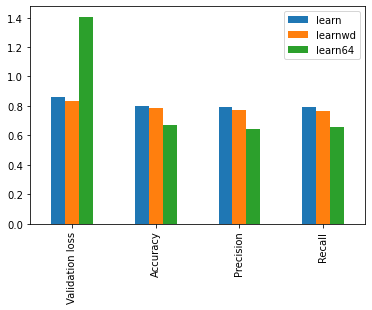

In [91]:
df_acc.T.plot(kind='bar')

We can see our learn model is the best one. It beats the other models in Accuracy, Precision and Recall which are the most important metrics. There is no reason not to prefer it over other models here. 

### Let's see and example

In [98]:
out = learn.predict("img/bishop_resized/00000025_resized.jpg")

In [96]:
out

('bishop_resized',
 TensorBase(2),
 TensorBase([1.6576e-01, 2.3826e-07, 8.3398e-01, 8.4896e-07, 2.5550e-04]))

The following code is heavily inspired from an old project I did. It simply makes it possible to upload pictures and have the model do inference on them interactively in the jupyter notebook. 

In [100]:
from fastai.vision.all import *
from fastai.vision.widgets import *

In [109]:
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()


def on_data_change(change):
    lbl_pred.value = ""
    
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl:
        display(img.to_thumb(224,244))
    
    pred, pred_idx, probs = learn.predict(img)
    
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [106]:
btn_upload.observe(on_data_change, names=['data'])

# Display Predictions
display(VBox([widgets.Label('Upload Chess piece'), btn_upload, out_pl, lbl_pred]))

Disclaimer: This code for the prediction button is inspired from a project I did years ago. 